`Name: Syam Immanuel Paul Bondada`

`Roll No: 230853737`

In [1]:
!pip install nltk

In [2]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gender_guesser

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install nlpaug

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install nltk textblob

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [7]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/syamimmanuelpaulbondada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/syamimmanuelpaulbondada/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/syamimmanuelpaulbondada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
from sklearn.feature_extraction import DictVectorizer


import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/syamimmanuelpaulbondada/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


In [11]:
def create_character_document_from_dataframe(df, max_line_count, context_size=5):
    """
    Returns a dict with the name of the character as key, their lines and a limited context of lines 
    from other characters in the same scene joined together as a single string.
    """
    character_docs = {}
    character_line_count = {}

    # Group by episode and scene
    grouped = df.groupby(['Episode', 'Scene'])
    for (episode, scene), group in grouped:
        
        # Iterate over each character in the scene
        for name, line_group in group.dropna(subset=['Line']).groupby('Character_name'):
            if name not in character_docs:
                character_docs[name] = ""
                character_line_count[name] = 0

            if character_line_count[name] >= max_line_count:
                continue

            for idx in line_group.index:
                # Get context lines (limited by context_size)
                # Ensure the context is from the same scene and does not include the character's own lines
                context_before = group.loc[(group.index < idx) & (group['Character_name'] != name)].tail(context_size)['Line'].dropna().astype(str).tolist()
                context_after = group.loc[(group.index > idx) & (group['Character_name'] != name)].head(context_size)['Line'].dropna().astype(str).tolist()
                context = " EOL ".join(context_before + context_after)

                # Combine character's own lines with context
                character_lines = " EOL ".join(line_group.loc[idx].astype(str).tolist())
                character_docs[name] += character_lines + " _CONTEXT_START_ " + context + " _CONTEXT_END_ "
                character_line_count[name] += len(line_group.loc[idx])

    print("lines per character", character_line_count)
    return character_docs


In [12]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
Num. Characters:  10 

#ALL# Number of Words:  6851
Chandler Bing Number of Words:  7944
Joey Tribbiani Number of Words:  7389
Monica Geller Number of Words:  6824
Other_None Number of Words:  5271
Phoebe Buffay Number of Words:  6170
Rachel Green Number of Words:  8359
Ross Geller Number of Words:  6923
Other_Female Number of Words:  6877
Other_Male Number of Words:  5808
total words 68416


In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import re

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

def pre_process(character_text):

    
    # Removing extra spaces
    character_text = character_text.lower()
    character_text = re.sub(r'\s+', ' ', character_text).strip()
    
    # Tokenization (including removing punctuation)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(character_text)
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Custom Stopword Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Remove numbers
    tokens = [re.sub(r'\d', '', token) for token in tokens]
    
    # Lemmatization (selective)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syamimmanuelpaulbondada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/syamimmanuelpaulbondada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [15]:
from collections import Counter
from nltk import ngrams, word_tokenize, pos_tag
from textblob import TextBlob
import gender_guesser.detector as gender

def gender_classifier(text):
    detector = gender.Detector()
    gender_prediction = detector.get_gender(text.split()[0])  # Use the first word for prediction
    return gender_prediction

def extract_ngrams(tokens, n):
    return [' '.join(gram) for gram in ngrams(tokens, n)]

def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Improved version with bigrams, unigrams, POS tags, gender prediction, and sentiment analysis.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    
    # Token counts
    counts = Counter(character_doc)

    # N-grams (unigrams, bigrams, and trigrams)
    for n in range(1, 5):
        ngram_features = extract_ngrams(character_doc, n)
        ngram_counts = Counter(ngram_features)
        counts.update(ngram_counts)

    # POS tags
    pos_tags = pos_tag(word_tokenize(' '.join(character_doc)))
    pos_counts = Counter(tag for word, tag in pos_tags)
    counts.update(pos_counts)

    # Gender Prediction
    gender_prediction = gender_classifier(' '.join(character_doc))
    counts['gender_prediction'] = gender_prediction

    # Sentiment Analysis
    sentiment = TextBlob(' '.join(character_doc)).sentiment
    counts['sentiment_polarity'] = sentiment.polarity
    counts['sentiment_subjectivity'] = sentiment.subjectivity

    # Add the extra features
    for feature in extra_features:
        counts[feature] += 1

    return counts

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction import DictVectorizer

# Initialize the vectorizer and TF-IDF transformer
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False, feature_selection_k=None):
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        # Fit the DictVectorizer
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])

    # Transform to feature matrix
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    
    # TF-IDF transformation
    doc_feature_matrix_tfidf = tfidf_transformer.fit_transform(doc_feature_matrix)

    # Feature selection
    if feature_selection_k is not None:
        labels = [label for label, doc in corpus]
        feature_selector = SelectKBest(chi2, k=feature_selection_k)
        doc_feature_matrix_tfidf = feature_selector.fit_transform(doc_feature_matrix_tfidf, labels)

    return doc_feature_matrix_tfidf

# Example usage
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_selection_k=None)

In [17]:
training_feature_matrix

<10x28107 sparse matrix of type '<class 'numpy.float64'>'
	with 56610 stored elements in Compressed Sparse Row format>

In [18]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
Num. Characters:  10 

Other_None Num of Words:  582
Rachel Green Num of Words:  1032
Other_Male Num of Words:  777
#ALL# Num of Words:  617
Chandler Bing Num of Words:  808
Joey Tribbiani Num of Words:  694
Monica Geller Num of Words:  998
Phoebe Buffay Num of Words:  654
Ross Geller Num of Words:  817
Other_Female Num of Words:  771
total words 7750


In [19]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [20]:
val_feature_matrix

<10x28107 sparse matrix of type '<class 'numpy.float64'>'
	with 2188 stored elements in Compressed Sparse Row format>

In [21]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [22]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [23]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [24]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.0
mean cosine similarity 0.889408680356946
10 correct out of 10 / accuracy: 1.0


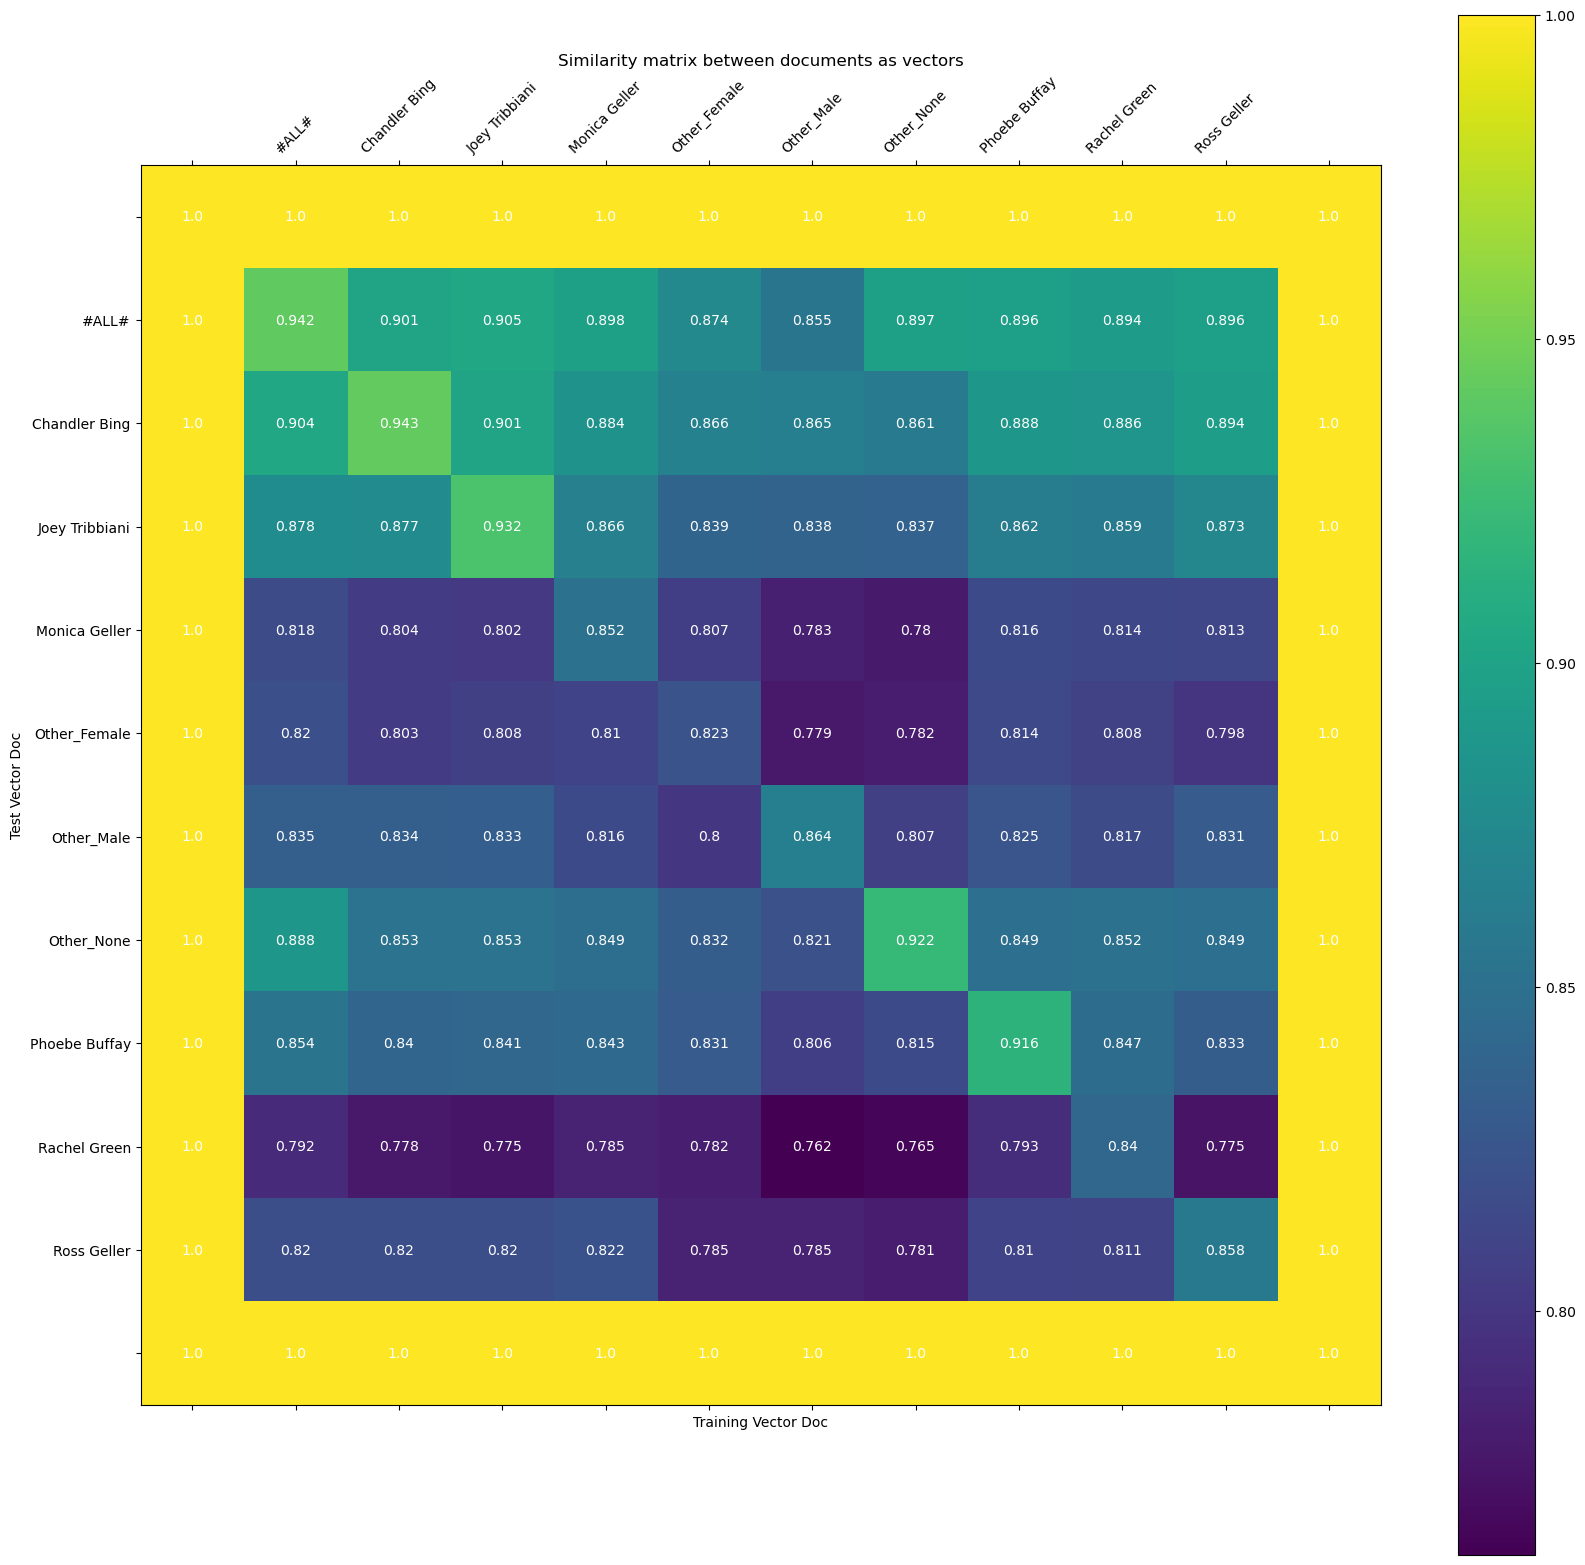

In [25]:
plot_heat_map_similarity(df)

In [26]:
from itertools import product

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def pre_process(character_text, args):
    
    result_tokens = []
    
    arg_1, arg_2, arg_3 = args

    # Initialize tokens before applying processing steps
    tokens = word_tokenize(character_text)

    # Processing based on arg_1
    if arg_1:
        # Removing extra spaces
        character_text = character_text.lower()
        character_text = re.sub(r'\s+', ' ', character_text).strip()
        
        # Tokenization (including removing punctuation)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(character_text)
        
         # Stemming
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
        
    # Processing based on arg_2
    if arg_2:
        
        # Remove numbers
        tokens = [re.sub(r'\d', '', token) for token in tokens]
       
        # Custom Stopword Removal
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
  
    # Processing based on arg_3
    if arg_3:
        
        # Lemmatization (selective)
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    result_tokens.extend(tokens)
    
    return result_tokens

In [27]:
arg_combinations = list(product([True, False], [True, False], [True, False]))
best_mean_rank = 10
for args in arg_combinations:
    # redo on training data with the first 300 character lines used
    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
    
    training_corpus = [(name, pre_process(doc, args)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]

    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

     # Get the test data using 30 lines per character
    test_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)

    test_corpus = [(name, pre_process(doc, args)) for name, doc in sorted(test_character_docs.items())]
    test_labels = [name for name, doc in test_corpus]


    test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)

    mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)
    # Update the best combination if the current mean rank is better
    if mean_rank < best_mean_rank:
        best_mean_rank = mean_rank
        best_arg_combination = args

# Example usage
# best_args = perform_grid_search(train_character_docs, val_character_docs)
print("Best Argument Combination:", best_arg_combination)

lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
mean rank 1.0
mean cosine similarity 0.889408680356946
10 correct out of 10 / accuracy: 1.0
lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
mean rank 1.0
mean cosine simila

In [28]:
def to_feature_vector_dictionary(character_doc, args):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Improved version with bigrams, unigrams, POS tags, gender prediction, and sentiment analysis.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    arg_4, arg_5, arg_6 = args
    
    # Token counts
    counts = Counter(character_doc)

    # N-grams (unigrams, bigrams, and trigrams)
    if arg_4:
        for n in range(1, 2):
            ngram_features = extract_ngrams(character_doc, n)
            ngram_counts = Counter(ngram_features)
            counts.update(ngram_counts)
            
    if arg_5:
        # POS tags
        pos_tags = pos_tag(word_tokenize(' '.join(character_doc)))
        pos_counts = Counter(tag for word, tag in pos_tags)
        counts.update(pos_counts)
        
    if arg_6:
        # Sentiment Analysis
        sentiment = TextBlob(' '.join(character_doc)).sentiment
        counts['sentiment_polarity'] = sentiment.polarity
        counts['sentiment_subjectivity'] = sentiment.subjectivity

    return counts

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction import DictVectorizer

# Initialize the vectorizer and TF-IDF transformer
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False, feature_selection_k=None):
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        # Fit the DictVectorizer
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, args) for name, doc in corpus])

    # Transform to feature matrix
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, args) for name, doc in corpus])
    
    # TF-IDF transformation
    doc_feature_matrix_tfidf = tfidf_transformer.fit_transform(doc_feature_matrix)

    # Feature selection
    if feature_selection_k is not None:
        labels = [label for label, doc in corpus]
        feature_selector = SelectKBest(chi2, k=feature_selection_k)
        doc_feature_matrix_tfidf = feature_selector.fit_transform(doc_feature_matrix_tfidf, labels)

    return doc_feature_matrix_tfidf

In [30]:
arg_combinations = list(product([True, False], [True, False], [True, False]))
best_mean_rank = 10
for args in arg_combinations:
    # redo on training data with the first 300 character lines used
    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
    
    training_corpus = [(name, to_feature_vector_dictionary(doc, args)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]

    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

     # Get the test data using 30 lines per character
    test_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)

    test_corpus = [(name, to_feature_vector_dictionary(doc, args)) for name, doc in sorted(test_character_docs.items())]
    test_labels = [name for name, doc in test_corpus]
    

    test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)

    mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)
    # Update the best combination if the current mean rank is better
    if mean_rank < best_mean_rank:
        best_mean_rank = mean_rank
        best_arg_combination = args

# Example usage
# best_args = perform_grid_search(train_character_docs, val_character_docs)
print("Best Argument Combination:", best_arg_combination)

lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
mean rank 2.4
mean cosine similarity 0.9925685767133091
6 correct out of 10 / accuracy: 0.6
lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
mean rank 2.4
mean cosine simila

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction import DictVectorizer

# Initialize the vectorizer and TF-IDF transformer
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=False, feature_selection_k=None):
    
    # Extract feature vectors for the corpus
    feature_dicts = [to_feature_vector_dictionary(doc, tfidf_params) for name, doc in corpus]
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        # Fit the DictVectorizer
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, args) for name, doc in corpus])

    # Transform to feature matrix
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, args) for name, doc in corpus])
    
    # TF-IDF transformation
    doc_feature_matrix_tfidf = tfidf_transformer.fit_transform(doc_feature_matrix)
    
    # Feature selection
    if feature_selection_k is not None:
        labels = [label for label, doc in corpus]
        feature_selector = SelectKBest(chi2, k=feature_selection_k)
        doc_feature_matrix_tfidf = feature_selector.fit_transform(doc_feature_matrix_tfidf, labels)


    return doc_feature_matrix_tfidf

In [32]:
from itertools import product
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer



tfidf_params = {
    'use_idf': True,  # Whether to use IDF (Inverse Document Frequency) weighting
    'smooth_idf': True,  # Smooth IDF by adding 1 to document frequencies
    'sublinear_tf': False,  # Apply sublinear TF scaling (logarithmic scaling) to term frequencies
}


# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(**tfidf_params)

# Define additional parameters to search for character document creation
character_doc_param_grid = {
    'max_line_count': [100, 200, 300],
    'context_size': [3, 5, 7]
}

best_overall_performance = float('-inf')
best_overall_params = {}
train_character_names = set(train_data['Character_name'].unique())
val_character_names = set(val_data['Character_name'].unique())

# Iterate over all combinations of parameters from the character_doc_param_grid
for character_doc_params in ParameterGrid(character_doc_param_grid):
    # Create character documents with the current parameters
    character_docs = create_character_document_from_dataframe(train_data, **character_doc_params)

    # Pre-process documents
    train_processed_docs = {name: pre_process(doc, args) for name, doc in character_docs.items() if name in train_character_names}
    val_processed_docs = {name: pre_process(doc, args) for name, doc in character_docs.items() if name in val_character_names}

    # Create training and validation corpus
    train_corpus = [(name, doc) for name, doc in train_processed_docs.items()]
    val_corpus = [(name, doc) for name, doc in val_processed_docs.items()]

    # Create document matrices
    training_feature_matrix = create_document_matrix_from_corpus(train_corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=True, feature_selection_k=None)
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=False, feature_selection_k=None)

    # Compute evaluation scores
    mean_rank, mean_cosine_similarity, accuracy, _ = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

    # Determine the best performing parameters
    if accuracy > best_overall_performance:
        best_overall_performance = accuracy
        best_overall_params = {'Best_parameters': character_doc_params}

# Output the best performing parameters
print("Best Overall Parameters:", best_overall_params)


lines per character {'#ALL#': 105, 'Chandler Bing': 120, 'Joey Tribbiani': 110, 'Monica Geller': 135, 'Other_None': 115, 'Phoebe Buffay': 100, 'Rachel Green': 120, 'Ross Geller': 105, 'Other_Female': 115, 'Other_Male': 125}
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
lines per character {'#ALL#': 210, 'Chandler Bing': 205, 'Joey Tribbiani': 215, 'Monica Geller': 255, 'Other_None': 230, 'Phoebe Buffay': 225, 'Rachel Green': 225, 'Ross Geller': 220, 'Other_Female': 210, 'Other_Male': 205}
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
lines per character {'#ALL#': 105, 'Chandler Bing': 120, 'Joey Tribbiani': 110, 'Monica Geller

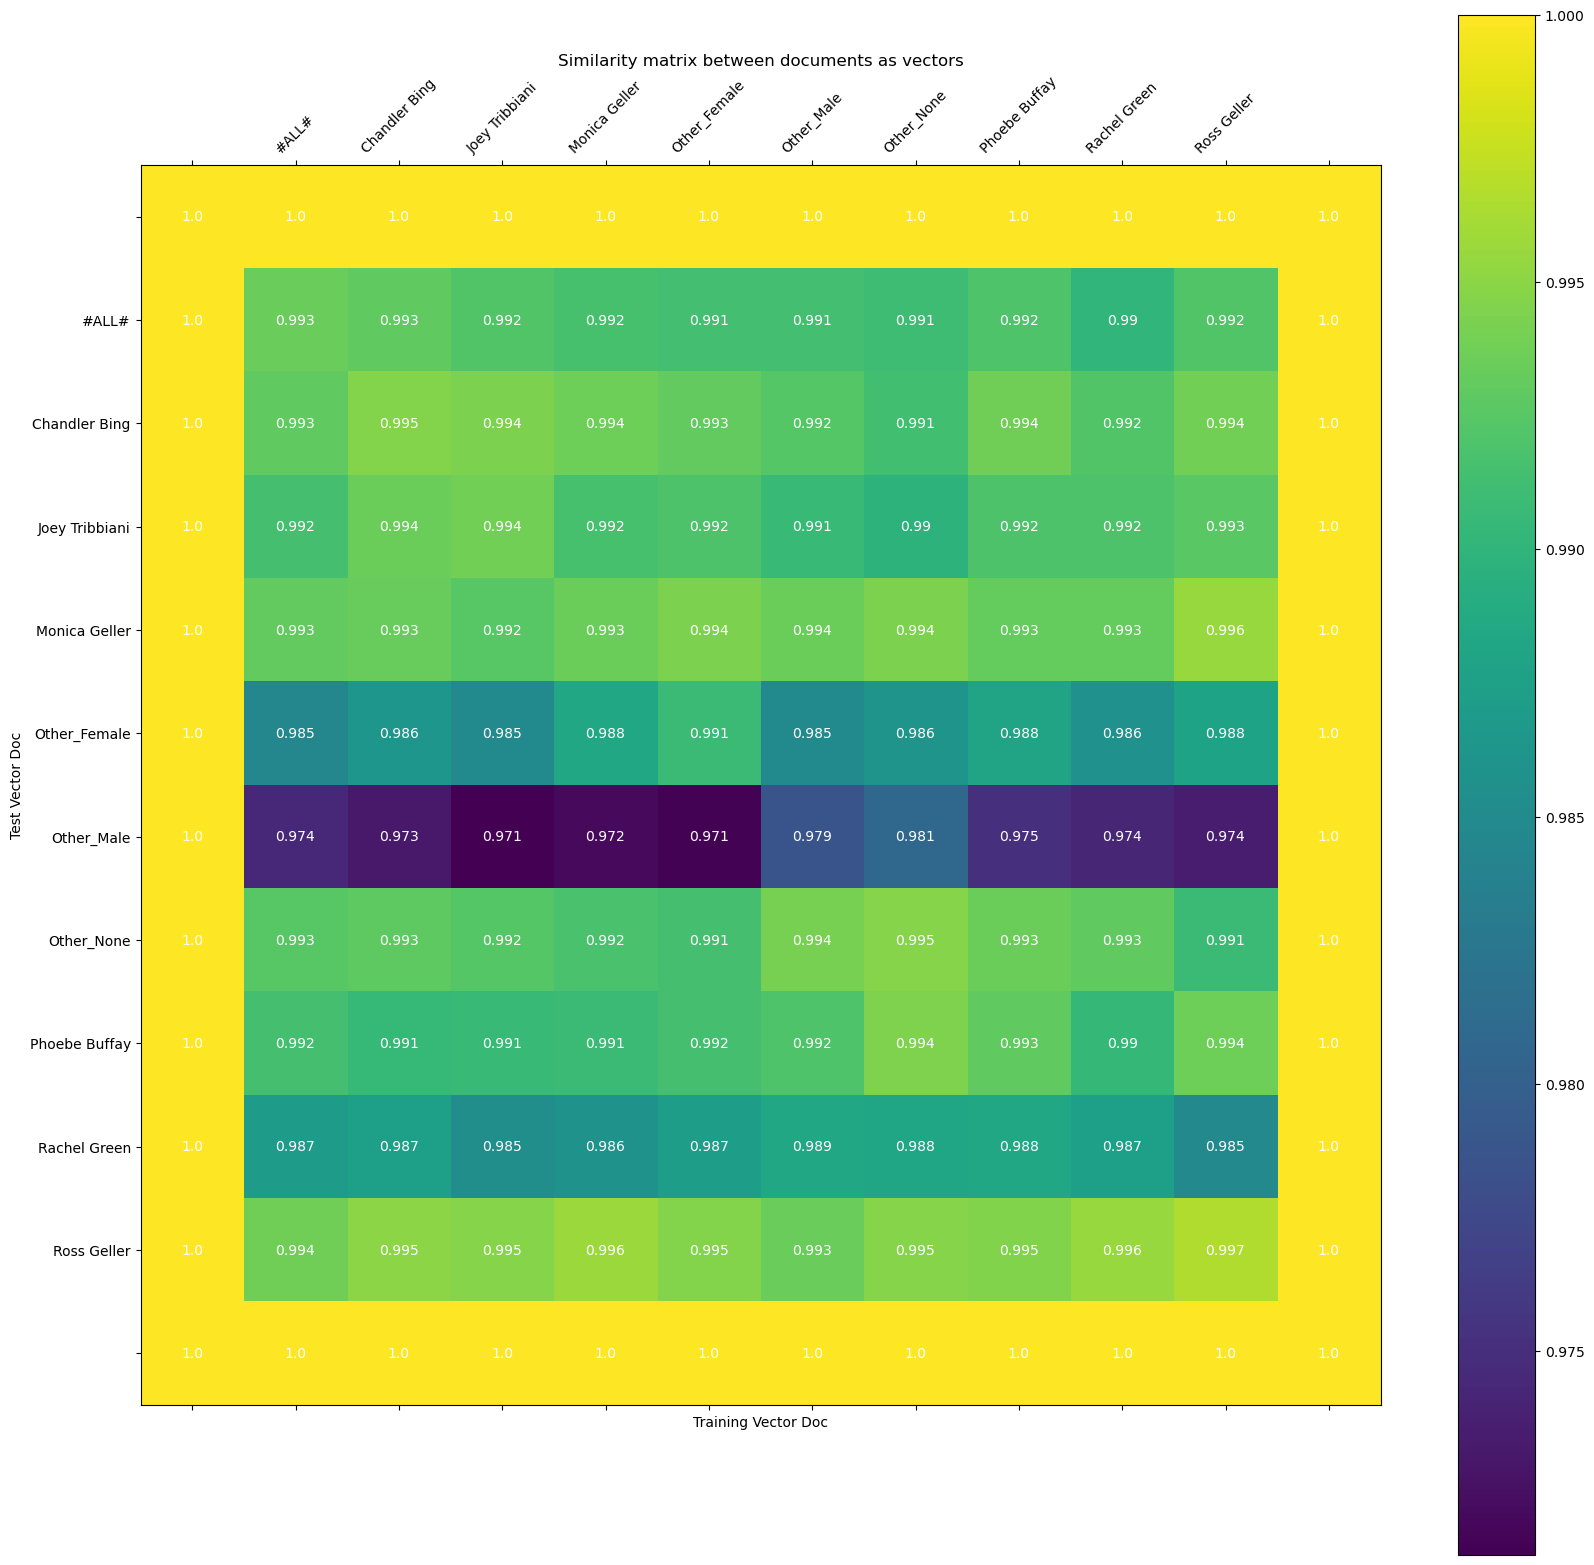

In [33]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()
plot_heat_map_similarity(df)

In [34]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc, args=(True, True, True))) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(train_corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=True, feature_selection_k=None)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc, args=(True, True, True))) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(train_corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=True, feature_selection_k=None)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
Num. Characters:  10 

#ALL# Number of Words:  6851
Chandler Bing Number of Words:  7944
Joey Tribbiani Number of Words:  7389
Monica Geller Number of Words:  6824
Other_None Number of Words:  5271
Phoebe Buffay Number of Words:  6170
Rachel Green Number of Words:  8359
Ross Geller Number of Words:  6923
Other_Female Number of Words:  6877
Other_Male Number of Words:  5808
total words 68416
lines per character {'Chandler Bing': 55, 'Joey Tribbiani': 30, 'Ross Geller': 60, '#ALL#': 30, 'Other_Female': 55, 'Other_None': 30, 'Monica Geller': 85, 'Phoebe Buffay': 40, 'Rachel Green': 30, 'Other_Male': 35}
Num. Characters:  10 

Chandler Bing Number of Words:  1144
Joey Tribbiani Number of Words:  667
Ross Geller Number of Words:  1220
#ALL# Number of Words:  545
Other_Fe